# 5. Features and Basis Functions

One can only get so far with linear regression, for two reasons:
* Linear models cannot capture the wide variety of functions that we might want to capture in supervised learning.
* There are many types of features that aren't naturally represented as vectors of real numbers.

The general approach is to introduce features or basis functions that create numerical vectors from a wide variety of different input types.

In [1]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## 5.1 Load and Explore the Data

For this lab, we will use the [UC Berkeley Salary Data](https://github.com/dailycal-projects/ucb-faculty-salary) from [2015](https://github.com/dailycal-projects/ucb-faculty-salary/tree/master/data/salary). We can explore a few rows to see what the data looks like.

In [2]:
df = pd.read_csv('../data/ucb-salary-2015.csv.gz', compression='gzip')
df['gross'] = df['gross'].str.replace(',', '')
df['gross'] = df['gross'].astype(int)
df.head(5)

,year,location,first,last,title,gross,regular,overtime,other
0,2015,Berkeley,ANNE,AABOE,BUS SYS ANL 4,124454,"124,454",0,0
1,2015,Berkeley,DAVID,AAKER,RECALL FACULTY,2500,0,0,"2,500"
2,2015,Berkeley,ELIZABETH,ABEL,PROF-AY,138775,"138,775",0,0
3,2015,Berkeley,NORMAN,ABRAHAMSON,ADJ PROF-AY-1/9-B/E/E,19668,"19,668",0,0
4,2015,Berkeley,BARBARA,ABRAMS,PROF-AY,191162,"169,862",0,"21,300"


Let's take a quick look at the highest titles by mean salary.

In [3]:
mean_salaries = pd.DataFrame(df.groupby(['title'])['gross'] \
                                              .mean() \
                                              .reset_index(name='mean') \
                                              .sort_values(['mean'], ascending=False))
mean_salaries[:10]

,title,mean
594,CHF INV OFCR,1106688.0
2624,SR MGN DIR FIXED INCOME ASSETS,1016853.0
583,CEO MED CTR,910590.0
1185,EXEC VP UC HEALTH,786745.0
2958,VC AND DEAN SOM,634752.0
827,COO MED CTR,609592.2
2193,PRESIDENT OF THE UNIV,584503.0
584,CFO HEALTH SYS AND CAMPUS,551574.0
711,CMO MED CTR,542879.0
2579,SENATE EMERITUS (WOS),538834.0


There are a lot of CEO, CFO, CMO titles in the upper salary titles. Let's create a "C-SUITE" title category, and then create a dataframe that contains all of these titles, plus all of the academic year faculty.

In [5]:
df['title'] = df['title'].str.replace(r'.*C[EFM]O.*', 'C-SUITE')

msdf = pd.DataFrame(df.groupby(['title'])['gross'] \
                                              .count() \
                                              .reset_index(name='count') \
                                              .sort_values(['count'], ascending=False))

ms_prof = msdf[(msdf['title'].str.contains('PROF-AY')) |
               (msdf['title'].str.contains('C-SUITE'))
              ]
ms_prof[:50]

,title,count
2241,PROF-AY,3334
317,ASSOC PROF-AY,1387
2244,PROF-AY-B/E/E,1139
365,ASST PROF-AY,980
368,ASST PROF-AY-B/E/E,366
319,ASSOC PROF-AY-B/E/E,313
2246,PROF-AY-LAW,158
340,ASST ADJ PROF-AY,142
90,ADJ PROF-AY,83
286,ASSOC ADJ PROF-AY,49


Let's visualize the distribution of salaries in each of these title classes compared to the C-Suite employees by creating a dataframe that contains the academic year professors, plus the C-Suite employees, with each of these titles in a separate column.  We can group each of these by title and sort the bars by median.

In [6]:
titles = [
          'C-SUITE',
          'PROF-AY-LAW', 
          'ASST PROF-AY', 'ASSOC PROF-AY', 'PROF-AY',
          'ASST ADJ PROF-AY', 'ASSOC ADJ PROF-AY', 'ADJ PROF-AY',  'ACT ASST PROF-AY', 
          'PROF-AY-B/E/E', 'ASSOC PROF-AY-B/E/E', 'ASST PROF-AY-B/E/E'
         ]

df_profs = df[df['title'].isin(titles)]
df_index = df_profs.groupby('title').median()['gross'].sort_values().index

[Text(0, 0, 'ACT ASST PROF-AY'),
 Text(0, 0, 'ASST ADJ PROF-AY'),
 Text(0, 0, 'ASSOC ADJ PROF-AY'),
 Text(0, 0, 'ADJ PROF-AY'),
 Text(0, 0, 'ASST PROF-AY'),
 Text(0, 0, 'ASSOC PROF-AY'),
 Text(0, 0, 'ASST PROF-AY-B/E/E'),
 Text(0, 0, 'ASSOC PROF-AY-B/E/E'),
 Text(0, 0, 'PROF-AY'),
 Text(0, 0, 'PROF-AY-B/E/E'),
 Text(0, 0, 'PROF-AY-LAW'),
 Text(0, 0, 'C-SUITE')]

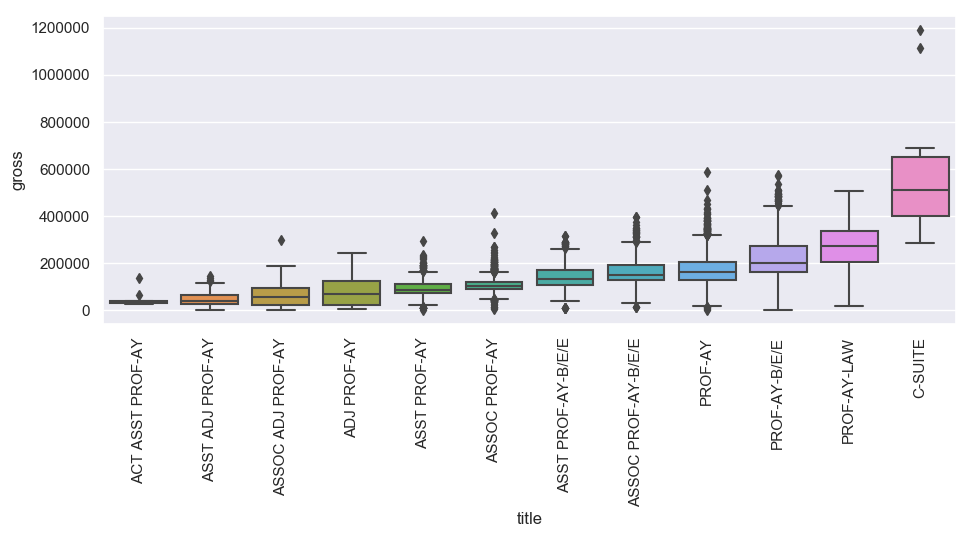

In [7]:
sns.set(rc={'figure.figsize':(11, 4)})
ax = sns.boxplot(x="title", y="gross", data=df_profs, order=df_index)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

## 5.2 Linear Regression

We'll try to fit the above salaries to titles using linear regression, using standard features and a polynomial feature expansion.

### 5.2.1 Polynomial Feature Expansion

Recall that one of the benefits of a polynomial feature expansion is that it is possible to encode features that are non-real valued (in this case, title) and try to fit a linear model to the resulting polynomial expansion.

We will do that below.  Let's first create the regular features and then the polynomial expansion.


In [8]:
df_median = pd.DataFrame(df_profs.groupby('title').median()['gross'].sort_values())
df_median.reset_index(inplace=True)

# Define Features and Target
features = df_median.index.values.reshape(-1,1)
target = df_median.loc[:,'gross']

# Polynomial Features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False)
pf = poly.fit_transform(features)

pf

array([[0.000e+00, 0.000e+00, 0.000e+00],
       [1.000e+00, 1.000e+00, 1.000e+00],
       [2.000e+00, 4.000e+00, 8.000e+00],
       [3.000e+00, 9.000e+00, 2.700e+01],
       [4.000e+00, 1.600e+01, 6.400e+01],
       [5.000e+00, 2.500e+01, 1.250e+02],
       [6.000e+00, 3.600e+01, 2.160e+02],
       [7.000e+00, 4.900e+01, 3.430e+02],
       [8.000e+00, 6.400e+01, 5.120e+02],
       [9.000e+00, 8.100e+01, 7.290e+02],
       [1.000e+01, 1.000e+02, 1.000e+03],
       [1.100e+01, 1.210e+02, 1.331e+03]])

### 5.2.2 Linear Regression Training and Testing

We now train the two linear models: one with regular features, and the other with polynomial features.

In [9]:
# 1. Linear Prediction
regr = LinearRegression()
lm = regr.fit(features,target)
y_hat = regr.predict(features)

# 2. Linear Prediction, Polynomial Feature
pregr = LinearRegression()
pm = pregr.fit(pf,target)
y2_hat = pregr.predict(poly.fit_transform(features))

Finally, we can plot the result and see the result.

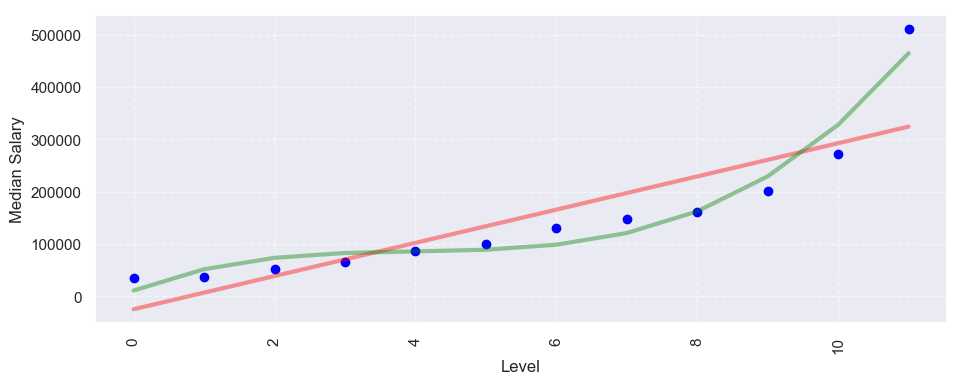

In [10]:
# Points
plt.plot(features, target, '.', color='blue', markersize=12)

# Linear Regression
plt.plot(features, y_hat, color='red', alpha=0.4, linewidth=3)
plt.plot(features, y2_hat, color='green', alpha=0.4, linewidth=3)

plt.grid(linestyle='--', alpha=0.6)
plt.xticks(rotation=90)
plt.xlabel('Level')
plt.ylabel('Median Salary')
plt.show()

### 5.2.3 Evaluating the Model

Comparing the RSS of the two models shows that the polynomial feature expansion indeed helped reduce the error.

In [11]:
from sklearn.metrics import mean_squared_error

print("""
RSS Linear Features:\t\t{} 
RSS Polynomial Features:\t{}
""".format(
            np.sqrt(mean_squared_error(target, y_hat)),
            np.sqrt(mean_squared_error(target, y2_hat)
                   )))


RSS Linear Features:		66473.79060403422 
RSS Polynomial Features:	28001.055567797048



## Plotting in Seaborn

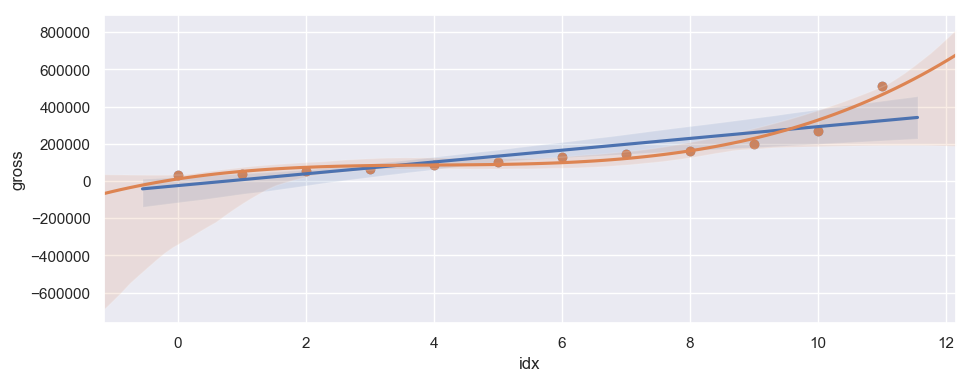

In [13]:
df_median['idx'] = df_median.index.values
sns.regplot('idx','gross',data=df_median.reset_index())
sns.regplot('idx','gross',data=df_median.reset_index(),order=3)